# Using VAEs as a Data Augmentation Technic
## Observations
 - Slightly improves f1-scores in few-shot scenarios
 - only yields improvments when generated samples do NOT dominate the original samples, i.e. do not generate more examples than the original dataset holds!
 - for non-few-shot scenarios the augmentation leads to faster and more stable convergence but not to an overall better performance of the model
 - often the f1-scores tend to rise faster when using additional generated data espiacially in early stages of training (first ~100 steps)
 - it seems like one cannot train the VAEs enough. The longer the better, which is weird because usually this means that the generated samples are very close to the original ones used for training

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from tqdm.notebook import trange
from pathlib import Path
import pandas as pd
import random

In [4]:
# set seed
seed = 83
# set cudnn backend to be deterministic
torch.backends.cudnn.deterministic = True
# utility function for seeding
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

## Hyperparameters

In [8]:
dataset_name = "                       diabetes          ".replace(" ", "")
mix_data =                             False
# consider reduced training sizes
n_total_examples =                     5
# total number of examples to be 
# generated
n_generated_perc =                     100
# Switches the way the number of 
# examples per class is computed
balancing =                            False
# latent space dimension for vae
vae_z_dim =                            2
# number of training steps for the vae
vae_training_steps =                   3000
# beta parameter of the kl-loss term
vae_beta =                             0.034
# batch size for vae training
vae_batch_size =                       8
# number of training steps for the gc
gc_training_steps =                    1000
# batch size for gan training
gc_batch_size =                        8
# std used for adjusting normal noise
gc_std =                               0.050
# number of training steps for the cnn
cls_training_steps =                   2000
# batch size for cnn training
cls_batch_size =                       32
# interval to evaluate model 
# during training
cls_eval_interval =                    20
# layer sizes
N =                                    512
M =                                    256
K =                                    128
# cuda
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)
# output dir for plots
plot_dir = Path(f"../plots/PROBEN1/{dataset_name}/runs/{n_total_examples}-{n_generated_perc}-{vae_z_dim}-{vae_training_steps}-{vae_beta}-{vae_batch_size}-{gc_training_steps}-{gc_batch_size}-{gc_std}-{cls_training_steps}-{cls_batch_size}-{cls_eval_interval}-{N}-{M}-{K}")
plot_root = Path(f"../plots/PROBEN1/{dataset_name}")
plot_root.mkdir(exist_ok=True, parents=True)
plot_dir.mkdir(exist_ok=True, parents=True)

Using device: cuda:0


## Data Preparation


In [9]:
seed_everything(seed)
# load data and labels
data = np.loadtxt(Path(f"../datasets/proben1/{dataset_name}_data.txt").expanduser())
labels = np.loadtxt(Path(f"../datasets/proben1/{dataset_name}_labels.txt").expanduser())
# remember the shape of the data
in_feat = data.shape[1]
n_classes = len(np.unique(labels))
# split data into train & test parts
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, stratify=labels, shuffle=True, random_state=seed)
print(f"class_counts = {np.unique(y_train, return_counts=True)[1]}")

# balancing factor
counts = np.unique(y_train, return_counts=True)[1]
n = counts.sum()
balance = -(counts / n * np.log(counts / n)).sum() / np.log(len(counts))
print(balance)

# convert testing data to tensors
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)
# Stratified KFold
# skf = StratifiedKFold(n_splits=2, random_state=seed, shuffle=True)
# # only use the first iteration of cross-validation
# seed_everything(seed)
# train_index, _ = next(iter(skf.split(x_train, y_train)))
# # select data by cross-validation index
# x_train, y_train = data[train_index], labels[train_index]
# separate train data into the different classes
if mix_data:
    train_per_label = []
    for i in range(n_classes):
        class_data = x_train[y_train == i]
        other_data = x_train[y_train != i]
        train_per_label.append(np.concatenate([class_data, other_data[np.random.permutation(len(other_data))[:len(class_data) // 4]]]))
else:
    train_per_label = [x_train[y_train == i] for i in range(n_classes)]
# reduce training size
if n_total_examples:
    train_per_label = [x_train[np.random.permutation(x_train.shape[0])[:n_total_examples]] for x_train in train_per_label]

class_counts = [400 214]
0.9327521564455291


In [10]:
# compute number of examples to generate for each class
n_total = sum([len(y_train[y_train == i]) for i in range(n_classes)])
# x is the proportion of each class in the dataset
x = np.array([count / n_total for count in np.unique(y_train, return_counts=True)[1]])
# if balancing the number of generated examples is computed differently
if balancing and not n_total_examples:
    n_generated_per_class = np.round((1 - x) / (n_classes - 1) * np.round(n_generated_perc * n_total)).astype('int')
elif not n_total_examples:
    n_generated_per_class = np.round(x * np.round(n_generated_perc * n_total)).astype('int')
else:
    n_generated_per_class = [len(X) * n_generated_perc for X in train_per_label]
# print class counts and number of generated per class
print(f"class_data_sizes = {[len(X) for X in train_per_label]}")
print(f"n_generated_per_class = {n_generated_per_class}")

class_data_sizes = [5, 5]
n_generated_per_class = [500, 500]


# Variational Auto-Encoder

In [7]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(in_feat, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
        )
        self.mean = nn.Linear(64, z_dim)
        self.log_variance = nn.Linear(64, z_dim)
    def forward(self, x):
        seq_out = self.sequential(x)
        # actually computes the log of the variance
        return self.mean(seq_out), self.log_variance(seq_out)
class Decoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(z_dim, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(512),
            nn.Linear(512, in_feat),
            nn.Sigmoid(),
        )
    def forward(self, z):
        return self.sequential(z)
class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
    def forward(self, x):
        # encode
        m, v_log = self.encoder(x)
        if self.training:
            # sample from encoding
            eps = torch.empty_like(v_log).normal_()
            z = eps * (v_log / 2).exp() + m
        else:
            z = m
        # decode from sample
        x_ = self.decoder(z)
        # return reconstruction, mean and log_variance
        return x_, m, v_log

In [8]:
seed_everything(seed)
# create one VAE model for each class
vae_per_label = [VAE(z_dim=vae_z_dim) for _ in range(n_classes)]

### Training the VAE Models

In [9]:
# train each vae on the specific data
for k, (X, vae) in enumerate(zip(train_per_label, vae_per_label)):
    r_losses, kl_losses = [], []
    X = torch.FloatTensor(X)
    # move vae to device and set it to train mode
    # also create an optimizer
    vae.to(device).train()
    optim = torch.optim.Adam(vae.parameters(), lr=2e-4, weight_decay=0.01)
    t = trange(vae_training_steps, leave=False)
    for i in t:
        # get batch to train from
        x_idx = np.random.randint(0, X.shape[0], vae_batch_size)
        x = X[x_idx].to(device)
        # predict and compute loss
        x_, m, v_log = vae(x)
        r_l = F.binary_cross_entropy(x_, x) * in_feat
        kl_l = (v_log.exp() + m**2 - 1 - v_log).sum(-1).mean()
        # update parameters
        optim.zero_grad()
        (r_l + vae_beta * kl_l).backward()
        optim.step()
        # update losses
        r_losses.append(r_l.item())
        kl_losses.append(kl_l.item())
        # update progress bar
        t.set_postfix({'r-loss': r_losses[-1], 'kl-loss': kl_losses[-1]})
    # close tqdm bar
    t.close()
    # move model back to cpu and 
    # set into eval mode after training
    # is finished
    vae.to('cpu').eval()
    # feedback
    print("k=%i\t r-loss: %.03f\t kl-loss: %.03f" % (k, r_losses[-1], kl_losses[-1]))

  0%|          | 0/3000 [00:00<?, ?it/s]

k=0	 r-loss: 9.921	 kl-loss: 10.274


  0%|          | 0/3000 [00:00<?, ?it/s]

k=1	 r-loss: 8.940	 kl-loss: 7.324


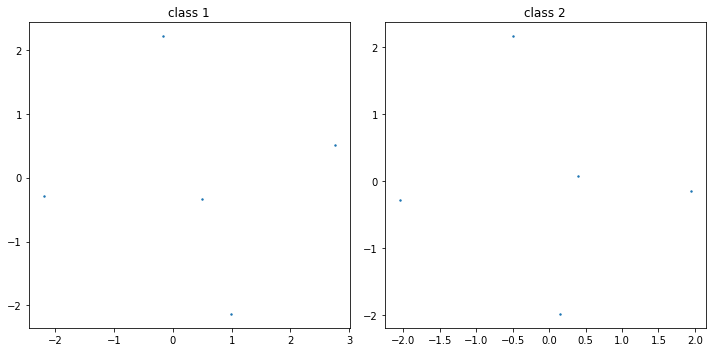

In [10]:
figure(tight_layout=True, figsize=(5 * n_classes, 5))
with torch.no_grad():
    for i, (vae, x_train) in enumerate(zip(vae_per_label, train_per_label), start=1):
        z = vae.encoder(torch.FloatTensor(x_train))[0]
        # plot
        subplot(1, n_classes, i)
        if z.shape[1] == 1:
            scatter(z, torch.zeros_like(z), s=2)
        elif z.shape[1] == 2:
            scatter(*z.T, s=2)
        else:
            scatter(*PCA(2).fit_transform(z).T, s=2)
        title(f"class {i}")
savefig(plot_dir / f"feature_space.pdf")
show()

Original Examples


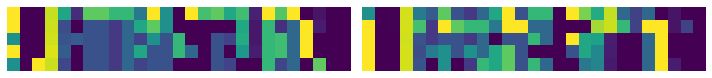

VAE Examples


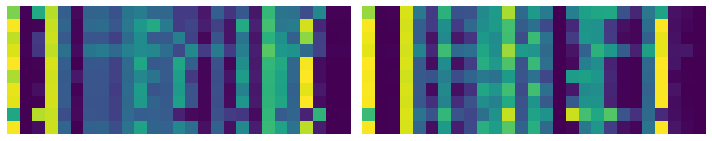

In [11]:
# plot original
print("Original Examples")
figure(tight_layout=True, figsize=(5 * n_classes, 5))
for i, X in enumerate(train_per_label, start=1):
    subplot(1, n_classes, i)
    imshow(X[:10].reshape(-1, in_feat))
    axis("off")
savefig(plot_dir / "original_data.pdf")
show()
# generate new examples from normal distribution
z_rand = torch.empty(10, vae_z_dim).normal_(0, 1)
with torch.no_grad():
    x_gen_per_class = [
        vae.decoder.forward(z_rand).reshape(-1, in_feat)
        for vae in vae_per_label
    ]
# plot vae examples
print("VAE Examples")
figure(tight_layout=True, figsize=(5 * n_classes, 5))
for i, x_gen in enumerate(x_gen_per_class, start=1):
    subplot(1, n_classes, i)
    imshow(x_gen.numpy())
    axis("off")
savefig(plot_dir / "vae_data.pdf")
show()

# Generative Classifier
We train a classifier to decide which images are generated by an vae and which ones aren't. By only training the model for a few steps we hope to ensure that the vae still generates images that are not discarded by the generative classifier.

In [12]:
class GenerativeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential( 
            # input size: in_feat
            nn.Linear(in_feat, N),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(N),
            nn.Dropout(0.1, inplace=True),
            # state size: N
            nn.Linear(N, M),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(M),
            nn.Dropout(0.1, inplace=True),
            # state size: M
            nn.Linear(M, K),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(K),
            nn.Dropout(0.1, inplace=True),
            # state size: K
            nn.Linear(K, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.sequential(x)

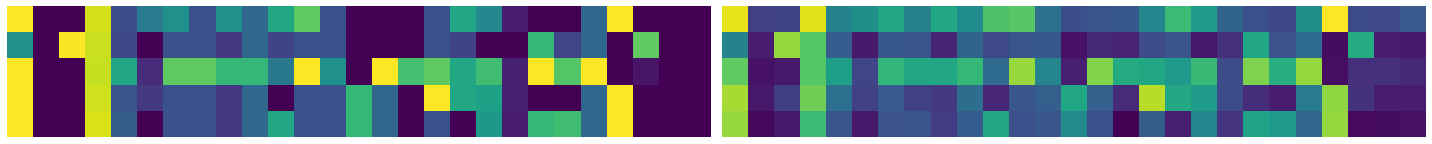

In [13]:
seed_everything(seed)
# build dataset of fake and real samples
real_x = torch.FloatTensor(np.concatenate(train_per_label, axis=0))
# create n/2 uniform distributed datapoints
uniform = torch.rand(size=(real_x.size(0) // 2, *real_x.size()[1:]))
# compute mean of dataset
feature_means = real_x.mean(dim=1)
# create n/2 normal distributed datapoints by adding normal noise to n/2 of the dataset
idx = torch.randperm(real_x.size(0))[: real_x.size(0) // 2]
# create normal noise with sample mean and std=0.3
normal = torch.stack([torch.normal(mean, gc_std, size=real_x.size()[1:]) for mean in feature_means[:real_x.size(0) // 2]], dim=0)
normal += real_x[idx]
# normalize normal noise examples
_min = normal.flatten(-2).min(-1)[0].unsqueeze(-1).unsqueeze(-1)
_max = normal.flatten(-2).max(-1)[0].unsqueeze(-1).unsqueeze(-1)
normal = (normal - _min) / (_max - _min)

# fake_x = torch.cat([uniform, normal], dim=0)
fake_x = torch.cat([uniform, normal], dim=0)
# create labels
real_y = torch.ones(real_x.size(0))
fake_y = torch.zeros(fake_x.size(0))
# pack into dataloader
gc_dataset = torch.utils.data.TensorDataset(torch.cat((real_x, fake_x), dim=0), torch.cat((real_y, fake_y), dim=0))
# visualize the data used to train the gc
_, (ax_original, ax_noisy) = subplots(1, 2, tight_layout=True, figsize=(20, 10))
num_vis = min(50, idx.size(0))
ax_original.imshow(real_x[idx][:num_vis].numpy().reshape(1, num_vis, 1, in_feat).transpose(1, 2, 0, 3).reshape(num_vis, in_feat))
ax_original.axis("off")
ax_noisy.imshow(normal[:num_vis].numpy().reshape(1, num_vis, 1, in_feat).transpose(1, 2, 0, 3).reshape(num_vis, in_feat))
ax_noisy.axis("off")
savefig(plot_dir / "gc_train_data.pdf")
show()

In [14]:
# train generative classifier
seed_everything(seed)
gc = GenerativeClassifier()
gc.to(device).train()
optim = torch.optim.Adam(gc.parameters(), lr=2e-4, weight_decay=0.01)

t = trange(gc_training_steps)
for i in t:
    # get batch to train on
    batch_idx = np.random.randint(0, len(gc_dataset), gc_batch_size)
    x, y_hat = gc_dataset[batch_idx]
    # apply model and compute loss
    y = gc.forward(x.to(device)).flatten()
    loss = F.binary_cross_entropy(y, y_hat.to(device))
    # update model parameters
    optim.zero_grad()
    loss.backward()
    optim.step()

# move classifier back to cpu
# and set it into evaluation mode
gc = gc.to('cpu').eval()

  0%|          | 0/1000 [00:00<?, ?it/s]

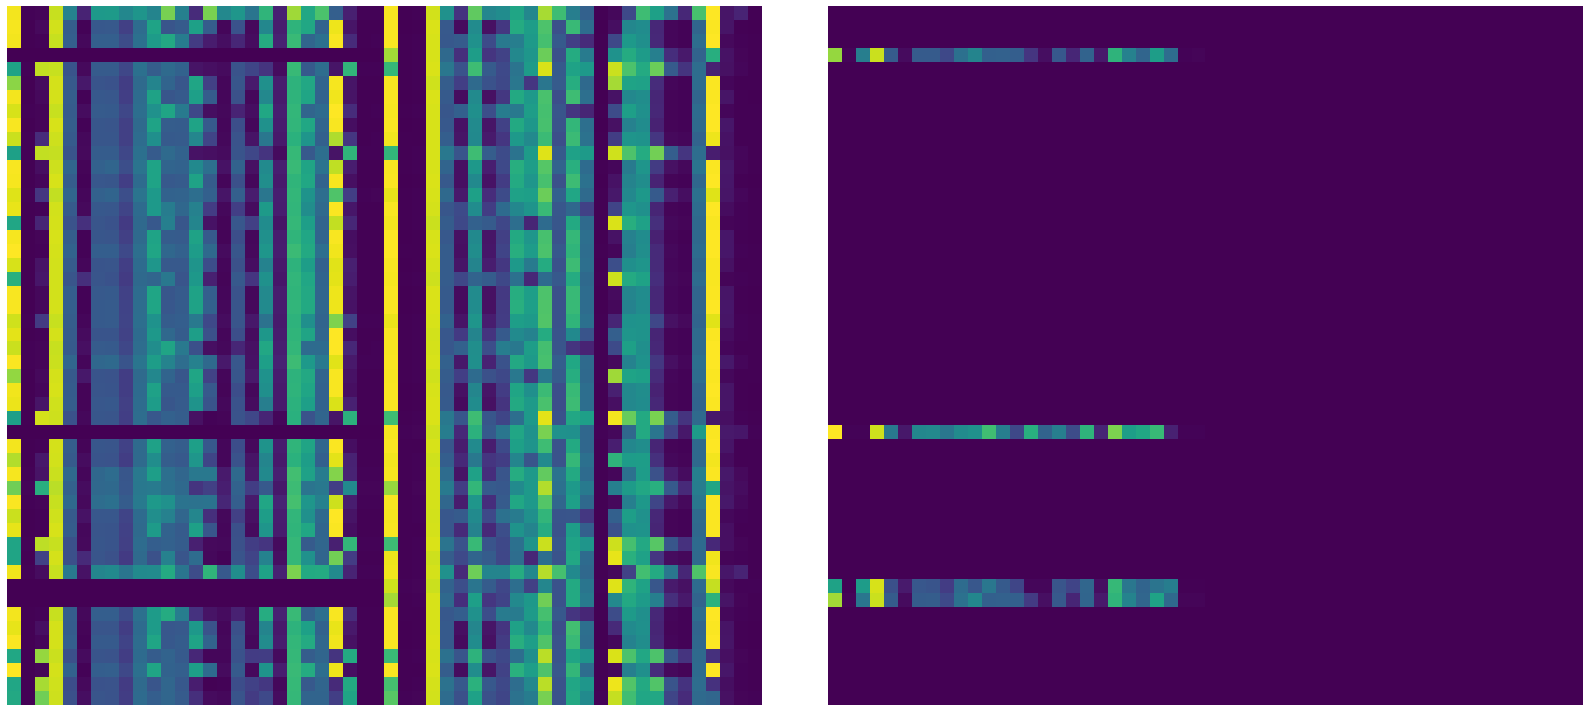

In [15]:
seed_everything(seed)
# generate some samples
with torch.no_grad():
    z_rand = torch.empty(50, vae_z_dim).normal_(0, 1)
    x_gen = torch.cat([
        vae.decoder.forward(z_rand)
        for vae in vae_per_label
    ], dim=0)
    # apply generative classifier
    mask = (gc.forward(x_gen) > 0.5).squeeze()
# convert to numpy
x_gen = x_gen.numpy()
mask = mask.numpy()
# apply mask
x_good, x_bad = x_gen.copy(), x_gen.copy()
x_good[~mask], x_bad[mask] = 0, 0

# visualize the choice of
# the generative classifier
_, (ax_good, ax_bad) = subplots(1, 2, tight_layout=True, figsize=(30, 10))
ax_good.imshow(x_good.reshape(n_classes, 50, 1, in_feat).transpose(1, 2, 0, 3).reshape(50, n_classes * in_feat))
ax_good.axis("off")
ax_bad.imshow(x_bad.reshape(n_classes, 50, 1, in_feat).transpose(1, 2, 0, 3).reshape(50, n_classes * in_feat))
ax_bad.axis("off")
savefig(plot_dir / "gc_good_bad.pdf")
show()

# CNN Model as Baseline

In [16]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            # input size: in_feat
            nn.Linear(in_feat, N),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(N),
            nn.Dropout(0.1, inplace=True),
            # state size: N
            nn.Linear(N, M),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(M),
            nn.Dropout(0.1, inplace=True),
            # state size: M
            nn.Linear(M, K),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(K),
            nn.Dropout(0.1, inplace=True),
            # state size: K
            nn.Linear(K, n_classes),
            nn.LogSoftmax(dim=-1)
        )
    def forward(self, x):
        return self.sequential(x)

### Training script for the CNN Model

In [17]:
def train_classifier(dataset):
    seed_everything(seed)
    # create a cnn model
    model = Classifier()
    # move model to device and set
    # it in train mode
    model.to(device).train()
    optim = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=0.01)
    # values we want to track
    train_losses, test_losses = [], []
    weighted_f1_scores, acc_scores = [], []
    # train loop
    t = trange(cls_training_steps)
    for i in t:
        # get batch to train from
        x_idx = np.random.randint(0, len(dataset), cls_batch_size)
        x, y_hat = dataset[x_idx]
        # apply model and compute loss
        y = model.forward(x.to(device))
        loss = F.nll_loss(y, y_hat.to(device))
        # update model parameters
        optim.zero_grad()
        loss.backward()
        optim.step()
        # add loss value to list
        train_losses.append(loss.item())

        if (i % cls_eval_interval == 0) or (i == vae_training_steps-1):
            # evaluate model
            model.eval()
            with torch.no_grad():
                # apply model to test data
                y = model.forward(x_test.to(device))
                loss = F.nll_loss(y, y_test.to(device))
                # add loss to list
                test_losses.append(loss.item())
                # get predictions and compute f1-scores
                y_pred = y.argmax(-1).cpu().numpy()
                weighted_f1_scores.append(f1_score(y_test.numpy(), y_pred, average='weighted'))
                acc_scores.append(accuracy_score(y_test.numpy(), y_pred))
            # back to training the model
            model.train()
    # move model back to cpu and
    # set it to evaluation mode
    model.to('cpu').eval()
    # return model and tracked values
    return model, {
        'train-losses': train_losses, 
        'test-losses':  test_losses, 
        'weighted-f1':  weighted_f1_scores, 
        'acc':          acc_scores
    }

### Training models
Here we train three models, i.e.
 - one trained on only the originally provided (reduced!) dataset
 - one trained on the original together with some generated samples
 - and one where the generated examples are filtered by the generative classifier

  0%|          | 0/2000 [00:00<?, ?it/s]

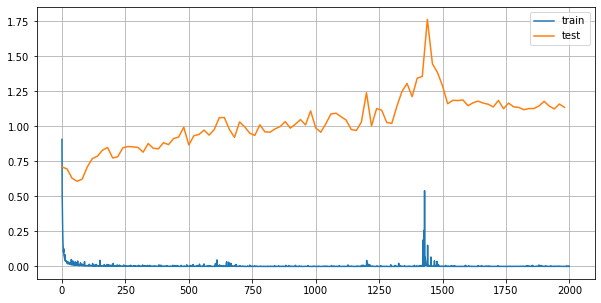

In [18]:
# build dataset of only the original samples
orig_train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(np.concatenate(train_per_label, axis=0)),
    torch.LongTensor(np.concatenate([
        (np.zeros(X.shape[0]) + i) for i, X in enumerate(train_per_label)
    ], axis=0))
)
# train model on dataset
model_orig, metrics_orig = train_classifier(orig_train_dataset)
# plot the losses
figure(figsize=(10, 5))
grid()
plot(metrics_orig['train-losses'], label='train')
ticks = [i * cls_eval_interval for i in range(len(metrics_orig['test-losses']))]
plot(ticks, metrics_orig['test-losses'], label='test')
legend()
savefig(plot_dir / "classifier_loss_orig.pdf")
show()

  0%|          | 0/2000 [00:00<?, ?it/s]

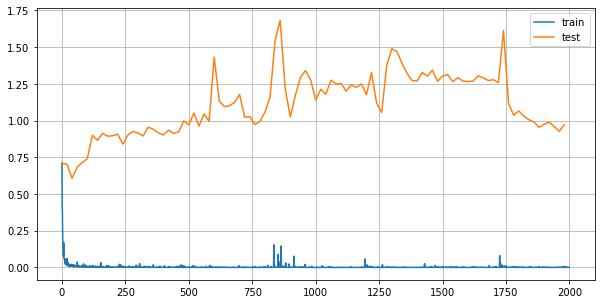

In [19]:
seed_everything(seed)
# build a dataset with both the original samples
# and also some generated ones using the vaes
with torch.no_grad():
    z_rand_per_class = [torch.empty(n_generated, vae_z_dim).normal_(0, 1) for n_generated in n_generated_per_class]
    generated_per_label = [
        vae.decoder.forward(z_rand).numpy()
        for (vae, z_rand) in zip(vae_per_label, z_rand_per_class)
    ]
# create a combined dataset from the original and generated samples
full_train_x = [
    np.concatenate(both, axis=0)
    for both in zip(train_per_label, generated_per_label)
]
full_train_y = [
    (np.zeros(X.shape[:1]) + i) 
    for i, X in enumerate(full_train_x)
]
# pack all of this in a dataset
full_train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(np.concatenate(full_train_x, axis=0)),
    torch.LongTensor(np.concatenate(full_train_y, axis=0))
)
# train model on both original and generated data
model_gen, metrics_gen = train_classifier(full_train_dataset)
# plot training and test losses
figure(figsize=(10, 5))
grid()
plot(metrics_gen['train-losses'], label='train')
ticks = [i * cls_eval_interval for i in range(len(metrics_gen['test-losses']))]
plot(ticks, metrics_gen['test-losses'], label='test')
legend()
savefig(plot_dir / "classifier_loss_full.pdf")
show()

Generated Examples: [500, 500]


  0%|          | 0/2000 [00:00<?, ?it/s]

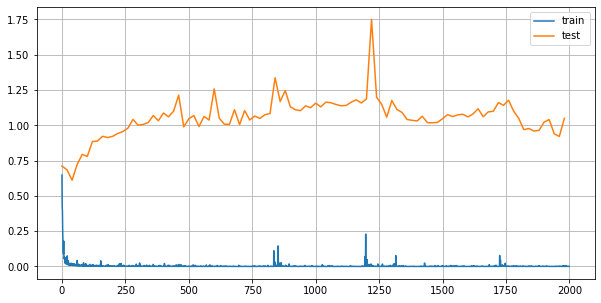

In [20]:
seed_everything(seed)
# build a dataset with both the original samples
# and also some generated ones using the vaes
with torch.no_grad():
    z_rand_per_class = [torch.empty(n_generated * 30, vae_z_dim).normal_(0, 1) for n_generated in n_generated_per_class]
    generated_per_label = [
        vae.decoder.forward(z_rand)
        for (vae, z_rand) in zip(vae_per_label, z_rand_per_class)
    ]
    # apply generative classifier
    masks_per_label = [
        gc.forward(x_gen).flatten() > 0.5
        for x_gen in generated_per_label
    ]
    generated_per_label = [
        x_gen[mask, ...].numpy()[:n_generated, ...]
        for x_gen, mask, n_generated in zip(generated_per_label, masks_per_label, n_generated_per_class)
    ]
    print(f"Generated Examples: {[x_gen.shape[0] for x_gen in generated_per_label]}")

# create a combined dataset from the original and generated samples
full_train_x = [
    np.concatenate(both, axis=0)
    for both in zip(train_per_label, generated_per_label)
]
full_train_y = [
    (np.zeros(X.shape[:1]) + i) 
    for i, X in enumerate(full_train_x)
]
# pack all of this in a dataset
full_train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(np.concatenate(full_train_x, axis=0)),
    torch.LongTensor(np.concatenate(full_train_y, axis=0))
)
# train model on both original and generated data
model_gen_gc, metrics_gen_gc = train_classifier(full_train_dataset)
# plot training and test losses
figure(figsize=(10, 5))
grid()
plot(metrics_gen_gc['train-losses'], label='train')
ticks = [i * cls_eval_interval for i in range(len(metrics_gen_gc['test-losses']))]
plot(ticks, metrics_gen_gc['test-losses'], label='test')
legend()
savefig(plot_dir / "classifier_loss_gc.pdf")
show()

### Comparisson of F1-Scores

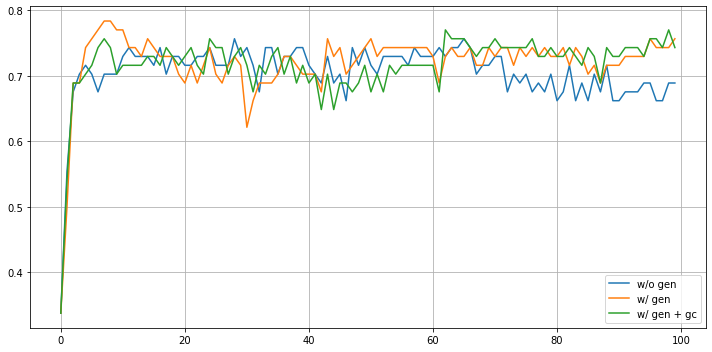

In [21]:
# also plot
figure(tight_layout=True, figsize=(10, 5))
grid()
plot(metrics_orig["acc"], label="w/o gen")
plot(metrics_gen["acc"], label="w/ gen")
plot(metrics_gen_gc["acc"], label="w/ gen + gc")
legend()
savefig(plot_dir / "accuracies_graph.pdf")
show()

# y = [
#     round(max(metrics_orig['acc']), 4),
#     round(max(metrics_gen['acc']), 4),
#     round(max(metrics_gen_gc['acc']), 4),
# ]
# figure(tight_layout=True, figsize=(10, 5))  
# barh([0, 1, 2], y, tick_label=["w/o gen", "w/ gen", "w/ gen + gc"])
# for i, v in enumerate(y):
#     plt.text(v, i, f" {str(v)}", color="blue", va="center", fontweight="bold")
# savefig(plot_dir / "accuracies.pdf")
# show()

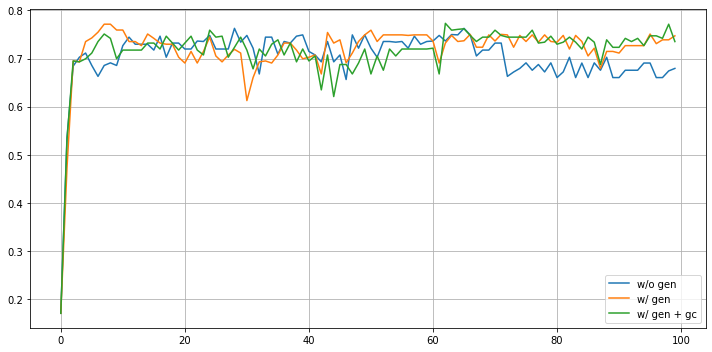

In [22]:
# also plot
figure(tight_layout=True, figsize=(10, 5))
grid()
plot(metrics_orig["weighted-f1"], label="w/o gen")
plot(metrics_gen["weighted-f1"], label="w/ gen")
plot(metrics_gen_gc["weighted-f1"], label="w/ gen + gc")
legend()
savefig(plot_dir / "weighted_f1_graph.pdf")
show()

# y = [
#     round(max(metrics_orig['weighted-f1']), 4),
#     round(max(metrics_gen['weighted-f1']), 4),
#     round(max(metrics_gen_gc['weighted-f1']), 4),
# ]
# figure(tight_layout=True, figsize=(10, 5))  
# barh([0, 1, 2], y, tick_label=["w/o gen", "w/ gen", "w/ gen + gc"])
# for i, v in enumerate(y):
#     plt.text(v, i, f" {str(v)}", color="blue", va="center", fontweight="bold")
# savefig(plot_dir / "weighted_f1.pdf")
# close()

In [23]:
df_results = pd.DataFrame.from_dict({
    "seed": [seed],
    "dataset_name": [dataset_name],
    "mix_data": [mix_data],
    "n_total_examples": [n_total_examples],
    "n_generated_perc": [n_generated_perc],
    "balancing": [balancing],
    "vae_z_dim": [vae_z_dim],
    "vae_training_steps": [vae_training_steps],
    "vae_beta": [vae_beta],
    "vae_batch_size": [vae_batch_size],
    "gc_training_steps": [gc_training_steps],
    "gc_batch_size": [gc_batch_size],
    "gc_std": [gc_std],
    "cls_training_steps": [cls_training_steps],
    "cls_batch_size": [cls_batch_size],
    "cls_eval_interval": [cls_eval_interval],
    "N": [N],
    "M": [M],
    "K": [K],
    "f1-orig": [round(max(metrics_orig["weighted-f1"]), 4)],
    "f1-gen": [round(max(metrics_gen["weighted-f1"]), 4)],
    "f1-gen+gc": [round(max(metrics_gen_gc["weighted-f1"]), 4)],
    "acc-orig": [round(max(metrics_orig["acc"]), 4)],
    "acc-gen": [round(max(metrics_gen["acc"]), 4)],
    "acc-gen+gc": [round(max(metrics_gen_gc["acc"]), 4)],
})
df_results[["f1-orig", "f1-gen", "f1-gen+gc", "acc-orig", "acc-gen", "acc-gen+gc"]].T

,0
f1-orig,0.7627
f1-gen,0.7714
f1-gen+gc,0.7731
acc-orig,0.7568
acc-gen,0.7838
acc-gen+gc,0.7703


In [24]:
results_path = plot_root / "results.csv"
if results_path.exists():
    df_saved = pd.read_csv(results_path, index_col=0, header=None).T
    df_results = pd.concat([df_saved, df_results])
df_results.T.to_csv(results_path, header=False)

In [25]:
import time
from IPython.display import display, Javascript
import hashlib

def save_notebook(file_path):
    start_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
    display(Javascript('IPython.notebook.save_checkpoint();'))
    current_md5 = start_md5
    
    while start_md5 == current_md5:
        time.sleep(1)
        current_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()

from nbconvert import HTMLExporter
import codecs
import nbformat

notebook_name = 'PROBEN1.ipynb'
output_file_name = plot_dir / 'output.html'

save_notebook(notebook_name)

exporter = HTMLExporter()
output_notebook = nbformat.read(notebook_name, as_version=4)

output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(output_file_name, 'w', encoding='utf-8').write(output)

<IPython.core.display.Javascript object>